In [1]:
# Heavily adapted from https://pytorch.org/tutorials/beginner/introyt/trainingyt.html and https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

from re import L
import sys
import os
main_folder_path = "./"
sys.path.append(main_folder_path)
import torch
import torch.nn as nn
import datetime as dt
import argparse
import subprocess
import ray.cloudpickle as pickle
import ray

import numpy as np
import tempfile
import pandas as pd

from ray import tune, train
from utils.dataset import VideoDataset
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
from models.cnn_split_lstm.cnn_split_lstm import CNN_Section, CNN_LSTM_Separate
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from pathlib import Path
from functools import partial
from utils.types import NonlinearityEnum
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = "cnn_split_lstm"
NOW = dt.datetime.now()
FILENAME = f"{NOW.strftime('%Y-%m-%d-%H-%M-%S')}"
SAVE_DIR = f"{main_folder_path}/models/cnn_split_lstm/saved_models"
DATA_FOLDER = "data"
INF = 100000000.
NUM_WORKERS = 8
NUM_CLASSES = 2
GPUS_PER_TRIAL = torch.cuda.device_count() if torch.cuda.is_available() else 0

timestamp = dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(f"runs/cnn_split_lstm_{timestamp}")



/home/wilsonwid/.local/share/virtualenvs/dsa4266-project-RvivrvFB/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-13 19:37:53,412	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-13 19:37:53,588	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-13 19:37:54.416983: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 19:37:54.425244: E external/local_xla/xla/stream_execut

In [2]:
cnn_search_space = {
    "input_channels": 3,
    "num_cnn_layers": 3,
    "num_start_kernels": 16,
    "kernel_size": 4,
    "stride": 2,
    "padding": 5,
    "dropout_prob": 0.05,
    "bias": False,
    "num_classes": NUM_CLASSES,
    "input_shape": (224, 224),
    "batch_size": 64,
    "lr": 0.00137748,
    "steps": 120,
    "nonlinearity": NonlinearityEnum.SILU,
    "include_additional_transforms": False,
}

cur_model = CNN_Section(
    input_channels=3,
    num_cnn_layers=3, 
    num_start_kernels=16,
    kernel_size=4,
    stride=2,
    padding=5,
    dropout_prob=0.05,
    bias=False,
    num_classes=NUM_CLASSES,
    input_shape=(224, 224),
    nonlinearity=NonlinearityEnum.SILU,
    train_alone=False
)

gpus_per_trial = GPUS_PER_TRIAL

scheduler = ASHAScheduler(
    time_attr="training_iteration",
    metric="val_acc",
    mode="max",
    max_t=10,
    grace_period=1,
    reduction_factor=2
)
directory = "/home/wilsonwid/ray_results/train_cnn_model_2024-11-13_00-32-51/train_cnn_model_c2cf0_00002_2_dropout_prob=0.0500,kernel_size=4,lr=0.0001,nonlinearity=ref_ph_2fdecf16,num_cnn_layers=3,num_start__2024-11-13_00-32-51/checkpoint_000001"

with open(f"{directory}/data.pkl", "rb") as f:
    checkpoint_data = pickle.load(f)
    cur_model.load_state_dict(checkpoint_data["net_state_dict"])

lstm_search_space = {
    "num_lstm_layers": 4,
    "hidden_size": 8,
    "dropout_prob": 0.2,
    "bidirectional": False,
    "steps": 128,
    "bias": False,
    "num_classes": NUM_CLASSES,
    "input_shape": (224, 224),
    "batch_size": 2,
    "lr": 0.0008447175,
    "nonlinearity": NonlinearityEnum.SILU,
    "include_additional_transforms": False,
}

cur_model_id = ray.put(cur_model)

best_trained_model = CNN_LSTM_Separate(
    cnn_section=cur_model,
    num_lstm_layers=lstm_search_space["num_lstm_layers"],
    hidden_size=lstm_search_space["hidden_size"],
    num_classes=NUM_CLASSES,
    bidirectional=lstm_search_space["bidirectional"],
    steps=lstm_search_space["steps"],
    bias=False,
    dropout_prob=lstm_search_space["dropout_prob"],
    nonlinearity=lstm_search_space["nonlinearity"]
)

lstm_directory = "/home/wilsonwid/ray_results/train_model_2024-11-13_17-11-29/train_model_44d73_00000_0_2024-11-13_17-11-29/checkpoint_000009"

with open(f"{lstm_directory}/data.pkl", "rb") as f:
    checkpoint_data = pickle.load(f)
    best_trained_model.load_state_dict(checkpoint_data["net_state_dict"])

25


2024-11-13 19:37:57,616	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [3]:
from torchviz import make_dot

In [4]:
torch_input = torch.randn(1, 128, 3, 224, 224)
y = best_trained_model(torch_input)

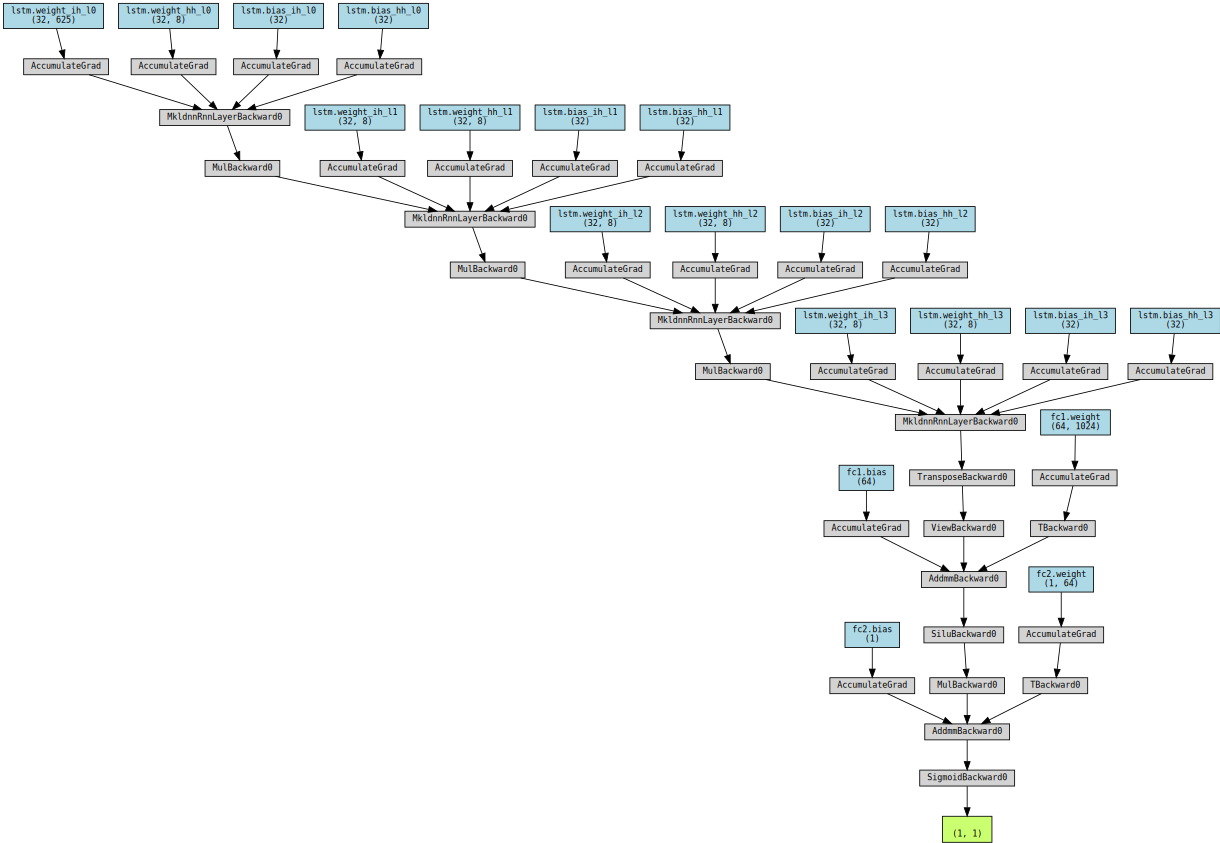

In [5]:
make_dot(y, params=dict(best_trained_model.named_parameters()))